In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import time
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('data/2012.csv', encoding='euc-kr')

In [3]:
for y in range(2013, 2023):
    new_df = pd.read_csv('data/{}.csv'.format(y), encoding='euc-kr')
    df = pd.concat([df, new_df])

In [4]:
df = df.reset_index(drop=True)


In [5]:
df.groupby('지점명').count()

,지점,일시,적설(cm),3시간신적설(cm)
지점명,,,,
강릉,475,475,475,0
강진군,717,717,717,40
강화,713,713,713,0
거제,27,27,27,0
거창,1730,1730,1729,91
...,...,...,...,...
합천,59,59,59,1
해남,392,392,392,1
홍성,1234,1234,1218,241


In [6]:
df['일시'][0]

'2012-01-01 00:00'

In [7]:
time.mktime(time.strptime(df['일시'][1], '%Y-%m-%d %H:%M')) - time.mktime(time.strptime(df['일시'][0], '%Y-%m-%d %H:%M'))


10800.0

In [8]:
def is_cont(df):
    point = np.array(df['지점'])
    location = np.array(df['지점명'])
    date = np.array(df['일시'])
    snow = np.array(df['적설(cm)']) * 10
    year = []
    month = []
    day = []
    hour = []
    strp = []
    mk = []
    continuous_1_hour = []
    continuous_3_hours = []
    continuous_6_hours = []

    for n, t in enumerate(date):
        t = time.strptime(t, '%Y-%m-%d %H:%M')
        strp.append(t)
        mk.append(time.mktime(t))
        year.append(t.tm_year)
        month.append(t.tm_mon)
        day.append(t.tm_mday)
        hour.append(t.tm_hour)

    for n, k in enumerate(mk):
        is_1_hour = (k + 3600.0 in mk)
        is_3_hours = (k + 10800.0 in mk)
        is_6_hours = (k + 21600.0 in mk)
        continuous_1_hour.append(is_1_hour)
        continuous_3_hours.append(is_3_hours)
        continuous_6_hours.append(is_6_hours)
    dic = {'point': point, 'location': location, 'snow': snow, 'year': year, 'month': month, 'day': day, 'hour': hour, 'con_1h': continuous_1_hour, 'con_3h': continuous_3_hours, 'con_6h': continuous_6_hours}
    df2 = pd.DataFrame(dic)
    return df2

In [310]:
df_90 = df[df['지점명']=='대관령'].fillna(0)
df_90 = df_90[df_90['적설(cm)']>0]

In [311]:
df2_90 = is_cont(df_90)


In [312]:
df2_90

,point,location,snow,year,month,day,hour,con_1h,con_3h,con_6h
0,100,대관령,224.0,2012,1,1,0,False,True,True
1,100,대관령,224.0,2012,1,1,3,True,True,True
2,100,대관령,224.0,2012,1,1,4,True,True,True
3,100,대관령,224.0,2012,1,1,5,True,True,True
4,100,대관령,224.0,2012,1,1,6,True,True,True
...,...,...,...,...,...,...,...,...,...,...
10076,100,대관령,6.0,2022,4,1,5,True,True,False
10077,100,대관령,6.0,2022,4,1,6,True,True,False
10078,100,대관령,6.0,2022,4,1,7,True,False,False
10079,100,대관령,6.0,2022,4,1,8,True,False,False


In [313]:
df2_90_train = df2_90[df2_90['year'] < 2018]
# df2_90_train = df[df['year'] < 2019]
df2_90_test = df2_90[df2_90['year'] == 2021]

In [314]:
df2_90_test

,point,location,snow,year,month,day,hour,con_1h,con_3h,con_6h
9606,100,대관령,8.0,2021,1,5,0,True,True,True
9607,100,대관령,12.0,2021,1,5,1,True,True,True
9608,100,대관령,17.0,2021,1,5,2,True,True,True
9609,100,대관령,17.0,2021,1,5,3,True,True,True
9610,100,대관령,11.0,2021,1,5,4,True,True,True
...,...,...,...,...,...,...,...,...,...,...
9826,100,대관령,6.0,2021,11,10,9,True,False,False
9827,100,대관령,6.0,2021,11,10,10,True,False,False
9828,100,대관령,5.0,2021,11,10,11,False,False,False
9829,100,대관령,3.0,2021,12,7,12,True,False,False


In [315]:
def make_cluster_in_order(df):
    snow = np.log(np.array(df['snow'])).reshape(-1, 1)
    kmeans = KMeans(n_clusters=20)
    clusters = kmeans.fit(snow)
    df['cluster']=clusters.labels_
    minmax = []

    dtype = [('min', float), ('max', float), ('idx', int)]
    for i in set(df['cluster']):
        cc = df[df['cluster'] == i]
        minmax.append((cc['snow'].min(), cc['snow'].max(), i))

    # minmax = np.sort(minmax, axis=0)
    minmax = np.array(minmax, dtype=dtype)
    minmax = np.sort(minmax, axis=0, order='min')
    
    cluster_in_order = []
    for n, sn in enumerate(df['snow']):
        for k, m in enumerate(minmax):
            if m[0] <= sn <= m[1]:
                cluster_in_order.append(k)
    df['cluster'] = cluster_in_order
    
    
    return df, minmax
            

    

In [316]:
def make_cluster_test_data(df, minmax):
    cluster_test = []
    snow = (np.array(df['snow']))
    for n, sn in enumerate(df['snow']):
        for k, m in enumerate(minmax):
            if k == len(minmax) - 1:
                cluster_test.append(k)
                break
            elif m[0] <= sn < minmax[k+1][0]:
                cluster_test.append(k)
                break
    df['cluster'] = cluster_test
    
    return df
                

In [317]:
df2_90_train, minmax = make_cluster_in_order(df2_90_train)
df2_90_train
print(minmax)

C:\Users\fembem\anaconda3\envs\torch-1.10.1\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=28.
  warnings.warn(
C:\Users\fembem\AppData\Local\Temp\ipykernel_16812\88306122.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster']=clusters.labels_


[(  1.,   1.,  6) (  2.,   2., 12) (  3.,   4., 17) (  5.,   5.,  1)
 (  6.,   8., 18) (  9.,  12.,  7) ( 13.,  17., 15) ( 18.,  22., 14)
 ( 23.,  27.,  2) ( 28.,  34., 13) ( 35.,  46.,  9) ( 47.,  65.,  5)
 ( 66.,  87.,  8) ( 88., 111., 19) (112., 146.,  0) (147., 192., 10)
 (193., 255.,  4) (256., 340., 16) (342., 442.,  3) (445., 740., 11)]


C:\Users\fembem\AppData\Local\Temp\ipykernel_16812\88306122.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = cluster_in_order


In [318]:
markov = np.zeros((20, 20))

In [319]:
for n, cl in enumerate(df2_90_train['cluster']):
    if n == len(df2_90_train['cluster'])-1:
        break
    markov[cl][df2_90_train['cluster'][n+1]] += 1

In [320]:
markov_prob = np.zeros(markov.shape)
for n, row in enumerate(markov):
    row /= np.sum(row)
    markov_prob[n] = row

In [321]:
hours = 6

In [322]:
for i in range(hours - 1):
    markov_prob = markov_prob @ markov_prob

In [323]:
markov_cum = np.zeros(markov.shape)
for n, row in enumerate(markov_prob):
    for m in range(len(row)):
        markov_cum[n][m] = np.sum(row[:m+1])

In [324]:
markov_cum

array([[2.47282066e-02, 5.50281161e-02, 1.08070090e-01, 2.09083084e-01,
        2.69654118e-01, 3.93341950e-01, 4.76482846e-01, 5.45561260e-01,
        6.38090619e-01, 7.63888490e-01, 8.59499420e-01, 9.25786397e-01,
        9.58427198e-01, 9.84253773e-01, 9.95300956e-01, 9.99433089e-01,
        9.99980302e-01, 9.99999218e-01, 9.99999981e-01, 1.00000000e+00],
       [2.39416388e-02, 5.33381366e-02, 1.04842401e-01, 2.03239489e-01,
        2.62235205e-01, 3.83199345e-01, 4.64834017e-01, 5.33224394e-01,
        6.25415192e-01, 7.52593454e-01, 8.50017517e-01, 9.19179906e-01,
        9.54354714e-01, 9.82057471e-01, 9.94552382e-01, 9.99301597e-01,
        9.99974108e-01, 9.99998900e-01, 9.99999972e-01, 1.00000000e+00],
       [2.32397912e-02, 5.18111425e-02, 1.01895186e-01, 1.97791518e-01,
        2.55284229e-01, 3.73523176e-01, 4.53537991e-01, 5.21029487e-01,
        6.12463259e-01, 7.40362417e-01, 8.39375733e-01, 9.11683741e-01,
        9.49903540e-01, 9.79802202e-01, 9.93745603e-01, 9.9915

In [325]:
df2_90_test = make_cluster_test_data(df2_90_test, minmax)

C:\Users\fembem\AppData\Local\Temp\ipykernel_16812\3962409001.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = cluster_test


In [326]:
df2_90_test.groupby('cluster').count()

,point,location,snow,year,month,day,hour,con_1h,con_3h,con_6h
cluster,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1
2,9,9,9,9,9,9,9,9,9,9
3,3,3,3,3,3,3,3,3,3,3
4,18,18,18,18,18,18,18,18,18,18
5,28,28,28,28,28,28,28,28,28,28
6,26,26,26,26,26,26,26,26,26,26
7,13,13,13,13,13,13,13,13,13,13
8,6,6,6,6,6,6,6,6,6,6
9,27,27,27,27,27,27,27,27,27,27


In [327]:
pred_snow_ = []
for i in range(100):
    pred_cluster = [999] * hours
    for n, cl in enumerate(df2_90_test['cluster']):
        p = np.random.rand()
        row = markov_cum[cl]
        for k, r in enumerate(row):
            if p < r:
                pred_cluster.append(k)
                break
    pred_cluster = pred_cluster[:-hours]
    df2_90_test['pred_cluster'] = pred_cluster
    pred_snow = [0] * hours
    for n, cl in enumerate(df2_90_test['pred_cluster'][hours:]):
        a, b, _ = minmax[cl]
        pred_sn = np.random.uniform(a, b, 1)[0]
        pred_snow.append(pred_sn)
    pred_snow_.append(pred_snow)
pred_snow_ = np.array(pred_snow_)
pred_snow_.shape


C:\Users\fembem\AppData\Local\Temp\ipykernel_16812\1277007892.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_90_test['pred_cluster'] = pred_cluster


(100, 225)

In [328]:
mean = np.mean(pred_snow_, axis=0)
mean_95_ci = 2.576 * np.std(pred_snow_, axis=0) / np.sqrt(100)
df2_90_test['pred_snow_mean'] = mean
df2_90_test['pred_snow_low_int'] = mean - mean_95_ci
df2_90_test['pred_snow_high_int'] = mean + mean_95_ci

df2_90_test[-20:]

C:\Users\fembem\AppData\Local\Temp\ipykernel_16812\1921363074.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_90_test['pred_snow_mean'] = mean
C:\Users\fembem\AppData\Local\Temp\ipykernel_16812\1921363074.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_90_test['pred_snow_low_int'] = mean - mean_95_ci
C:\Users\fembem\AppData\Local\Temp\ipykernel_16812\1921363074.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

,point,location,snow,year,month,day,hour,con_1h,con_3h,con_6h,cluster,pred_cluster,pred_snow_mean,pred_snow_low_int,pred_snow_high_int
9811,100,대관령,25.0,2021,3,7,11,True,False,False,8,8,36.589226,28.139807,45.038646
9812,100,대관령,16.0,2021,3,7,12,True,False,False,6,5,39.024314,31.220108,46.828520
9813,100,대관령,8.0,2021,3,7,13,False,False,False,4,4,34.225348,25.689289,42.761408
9814,100,대관령,4.0,2021,11,9,21,True,True,True,2,6,38.978788,29.959267,47.998309
9815,100,대관령,4.0,2021,11,9,22,True,True,True,2,11,36.167076,28.226056,44.108095
9816,100,대관령,17.0,2021,11,9,23,True,True,True,6,11,30.680406,22.529671,38.831141
9817,100,대관령,17.0,2021,11,10,0,True,True,True,6,11,32.556258,24.510815,40.601701
9818,100,대관령,16.0,2021,11,10,1,True,True,True,6,1,31.290120,22.536632,40.043607
9819,100,대관령,15.0,2021,11,10,2,True,True,True,6,10,30.158325,23.089682,37.226968
9820,100,대관령,13.0,2021,11,10,3,True,True,True,6,8,27.821395,20.047793,35.594998


In [329]:
snow_test = df2_90_test['snow'][(df2_90_test[(df2_90_test['con_6h']==True)].index + hours)[:-6]]
pred_snow_test = df2_90_test['pred_snow_mean'][(df2_90_test[(df2_90_test['con_6h']==True)].index + hours)[:-6]]
pred_snow_low_int = df2_90_test['pred_snow_low_int'][(df2_90_test[(df2_90_test['con_6h']==True)].index + hours)[:-6]]
pred_snow_high_int = df2_90_test['pred_snow_high_int'][(df2_90_test[(df2_90_test['con_6h']==True)].index + hours)[:-6]]
snow_test.shape

(159,)

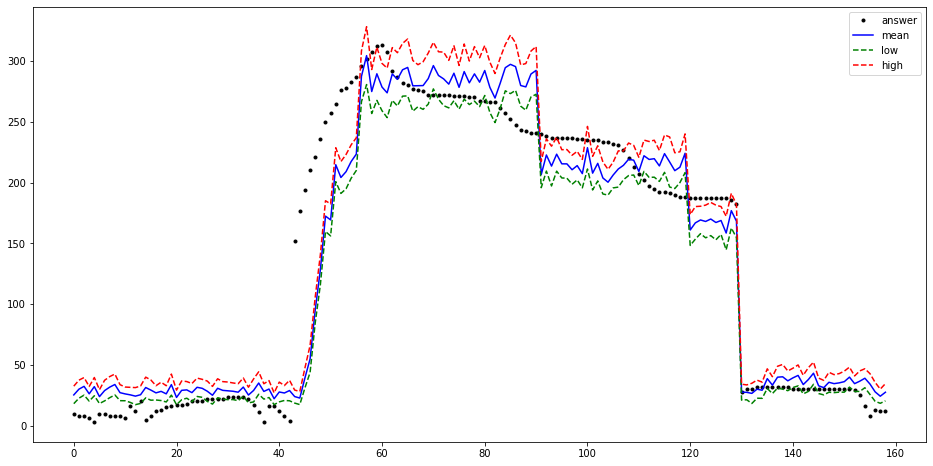

In [330]:
plt.figure(figsize=(16,8))
# plt.plot(df2_90_test['snow'], 'b.', label='answer')
# plt.plot(df2_90_test['pred_snow'], 'r--', label='pred')
x = range(len(snow_test))
plt.plot(x, snow_test, 'k.', label='answer')
# plt.plot(pred_snow_test, 'r--', label='pred')
# plt.fill_between(x, pred_snow_low_int, pred_snow_high_int)
plt.plot(x, pred_snow_test, 'b-', label='mean')
plt.plot(x, pred_snow_low_int, 'g--', label='low')
plt.plot(x, pred_snow_high_int, 'r--', label='high')

plt.legend()

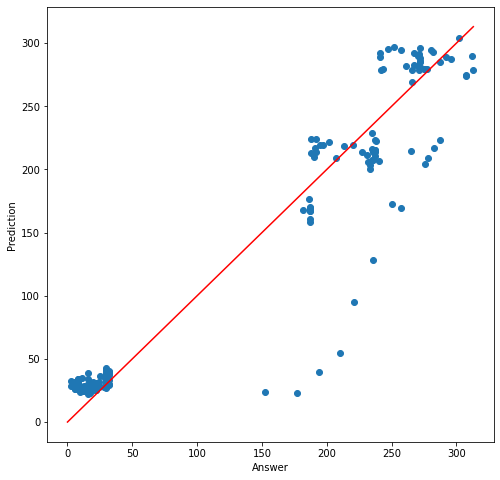

In [331]:
plt.figure(figsize=(8,8))
plt.scatter(snow_test, pred_snow_test)
plt.xlabel('Answer')
plt.ylabel("Prediction")
plt.plot([0, np.max(snow_test)], [0, np.max(snow_test)], 'r-')

In [332]:
np.sqrt(np.sum((snow_test - pred_snow_test) ** 2) / np.sum((pred_snow_test) ** 2))

0.20532141379313068

In [297]:
np.unique(np.array(df2_90_test['cluster'] == df2_90_test['pred_cluster']), return_counts=True)

(array([False,  True]), array([143, 143], dtype=int64))